## 加载数据 & DAG

In [1]:
causal_graph = """digraph G {
  HighlyDissatisfied [label="Highly Dissatisfied", color="green", style="filled"];
  Churn              [label="Churning out",         color="red",   style="filled"];
  Complain           [label="Complaint or not",     color="green", style="filled"];
  DaySinceLastOrder  [label="Days since Last order"];
  CityTier           [label="City Tier"];
  OrderCount         [label="Order Count"];
  CouponUsed         [label="Coupon Used"];
  Tenure             [label="Tenure with E Commerce"];
  WarehouseToHome    [label="Warehouse to Home Distance"];
  CashBackAmount     [label="Average Cashback in last month"];
  OrderAmountHikeFromlastYear [label="Percentage increases in order from last year"];
  PreferredLoginDevice        [label="Preferred Login Device"];
  HourSpendOnApp              [label="Total Hours Spend on App"];
  NumberOfAddress             [label="Number of Addresses"];
  NumberOfDeviceRegistered    [label="Number of device registered"];
  U [label="Unobserved Confounders", observed="false"];

  U -> HighlyDissatisfied;
  U -> CityTier;
  U -> Tenure;
  U -> CouponUsed;
  U -> WarehouseToHome;
  U -> PreferredLoginDevice;

  HighlyDissatisfied -> Churn;
  Complain -> Churn;
  Complain -> HighlyDissatisfied;
  DaySinceLastOrder -> Churn;
  DaySinceLastOrder -> OrderCount;
  CityTier -> OrderCount;
  CouponUsed -> OrderCount;
  CouponUsed -> OrderAmountHikeFromlastYear;
  OrderCount -> OrderAmountHikeFromlastYear;
  OrderAmountHikeFromlastYear -> Churn;
  Tenure -> OrderAmountHikeFromlastYear;
  WarehouseToHome -> CityTier;
  CashBackAmount -> OrderCount;
  PreferredLoginDevice -> HourSpendOnApp;
  HourSpendOnApp -> OrderCount;
  NumberOfAddress -> NumberOfDeviceRegistered;
  NumberOfDeviceRegistered -> OrderCount;
}"""

In [4]:

from src.data import load_and_clean, preprocess_ecommerce_data
from src.graph import CausalDAG
from src.model import CausalModel

df_raw = load_and_clean("e_commerce/EComm.csv")
df = preprocess_ecommerce_data(df_raw)

dag = CausalDAG.from_dot(causal_graph)
dag.to_png("causal_model.png")

## causal_graph


In [5]:
cm = CausalModel(df, dag, treatment="HighlyDissatisfied", outcome="Churn")
adj = cm.identify_effect()            # 取出后门集
ate, ci = cm.estimate_effect()         # PSW 估计
print("ATE:", ate, "CI:", ci)
print("Random common cause refute:", cm.refute('random_common'))
print("Subset refute:", cm.refute('subset', frac=0.8))

ATE: -0.07826779088996595 CI: (np.float64(-0.09868405898102761), np.float64(-0.059235883107810736))
Random common cause refute: {'orig': np.float64(-0.07826779088996595), 'new': np.float64(-0.07845397854044216)}
Subset refute: {'orig': np.float64(-0.07826779088996595), 'new': np.float64(-0.08132372871648685)}


## 可视化

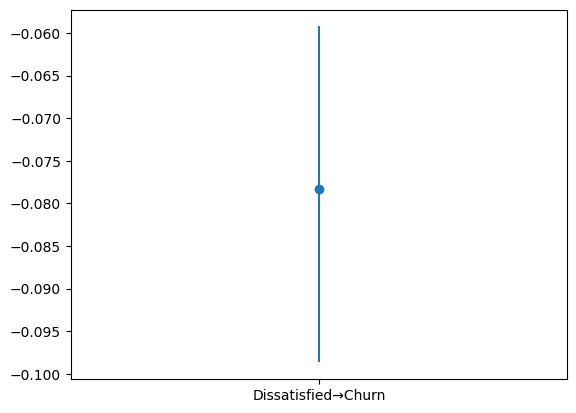

In [6]:
import matplotlib.pyplot as plt
plt.errorbar([0], [ate], yerr=[[ate-ci[0]], [ci[1]-ate]], fmt='o')
plt.xticks([0], ['Dissatisfied→Churn'])
plt.show()